In [1]:
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, top_k_accuracy_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("base_features.csv")
df['label'].value_counts()

label
good                   235721
phishing                73345
command_and_control     66490
spam                    46009
malware_hosting         16726
malvertising             3085
scanning_host             231
exploit_kit                82
cc_skimming                12
exploit_source              4
web_attack                  2
Name: count, dtype: int64

In [3]:
labels_with_few_samples = ['web_attack', 'exploit_source']
df = df[~(df['label'].isin(labels_with_few_samples))]
df['label'].value_counts()

label
good                   235721
phishing                73345
command_and_control     66490
spam                    46009
malware_hosting         16726
malvertising             3085
scanning_host             231
exploit_kit                82
cc_skimming                12
Name: count, dtype: int64

In [4]:
def column_adjustor(dataset_column):
    codes, uniques = pd.factorize(dataset_column)
    return pd.Series(codes, index=dataset_column.index), uniques.tolist()

In [5]:
_, labels = column_adjustor(df['label'])
{i: label for i, label in enumerate(labels)}

{0: 'phishing',
 1: 'malware_hosting',
 2: 'command_and_control',
 3: 'exploit_kit',
 4: 'scanning_host',
 5: 'malvertising',
 6: 'cc_skimming',
 7: 'spam',
 8: 'good'}

In [6]:
all_accuracy_scores = {}
all_shap_values = {"base_features": [], "cascade_1": [], "cascade_2": [], "cascade_3": [], "all_features": []}

In [7]:
longformer_urls = pd.read_csv("url_longformer.csv")
distilbert_urls = pd.read_csv("url_distilbert.csv")

In [8]:
scaler = MinMaxScaler()
scaled_longformer_urls = scaler.fit_transform(longformer_urls) 
scaled_distilbert_urls = scaler.fit_transform(distilbert_urls) 

# Base Features

1
2
3
4
5
6
7
8
9
10


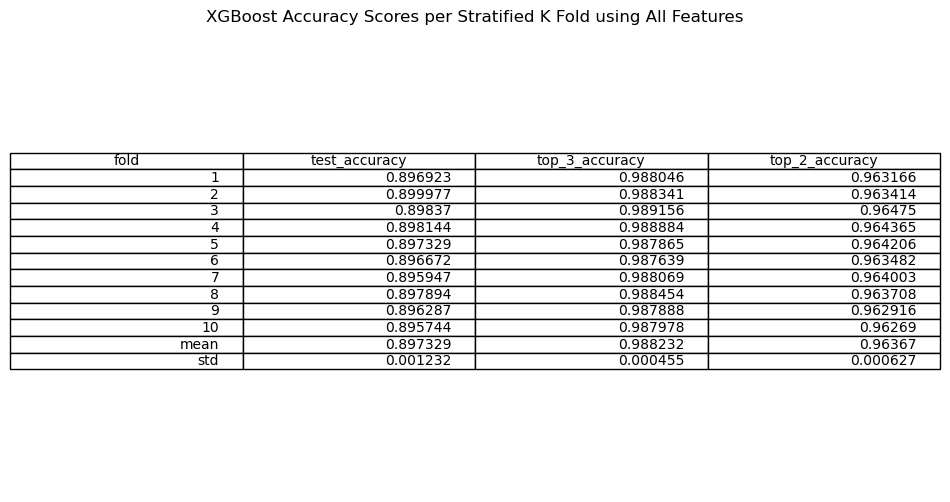

In [9]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)

lda = LinearDiscriminantAnalysis()
lda_scaled_longformer_urls = lda.fit_transform(scaled_longformer_urls, df['label'])
lda_scaled_distilbert_urls = lda.fit_transform(scaled_distilbert_urls, df['label'])
lda_scaled_longformer_urls_df = pd.DataFrame(lda_scaled_longformer_urls, columns=[f'longformer_embedding_{i}' for i in range(len(lda_scaled_longformer_urls[-1]))])
lda_scaled_distilbert_urls_df = pd.DataFrame(lda_scaled_distilbert_urls, columns=[f'distilbert_embedding_{i}' for i in range(len(lda_scaled_distilbert_urls[-1]))])
df = pd.concat([df, lda_scaled_longformer_urls_df, lda_scaled_distilbert_urls_df], axis=1)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)
df['label'], _ = column_adjustor(df['label'])
df['label'] = df['label'].astype(int)
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label']
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

np.set_printoptions(precision=2)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold + 1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout
plt.title("XGBoost Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [10]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
distilbert_embedding_0    27.820039%               
distilbert_embedding_1    8.020651%                
tld_transfer_price        5.903906%                
ratio_digits_hostname     4.602299%                
ratio_digits_url          4.110750%                
tld_renew_price           3.310228%                
url_length                3.129058%                
distilbert_embedding_2    3.036977%                
number_subdomains         2.890571%                
domain_length             2.569288%                
tld                       2.540232%                
unique_url_nums           2.532716%                
hostname_length           2.432058%                
num_hyphens               2.381742%                
tld_register_price        1.806099%                
num_semicolons            1.751315%                
longformer_embedding_0    1.736120%                
num_queries               1.283769%                
num_tlds_in_

# Cascade 1

1
2
3
4
5
6
7
8
9
10


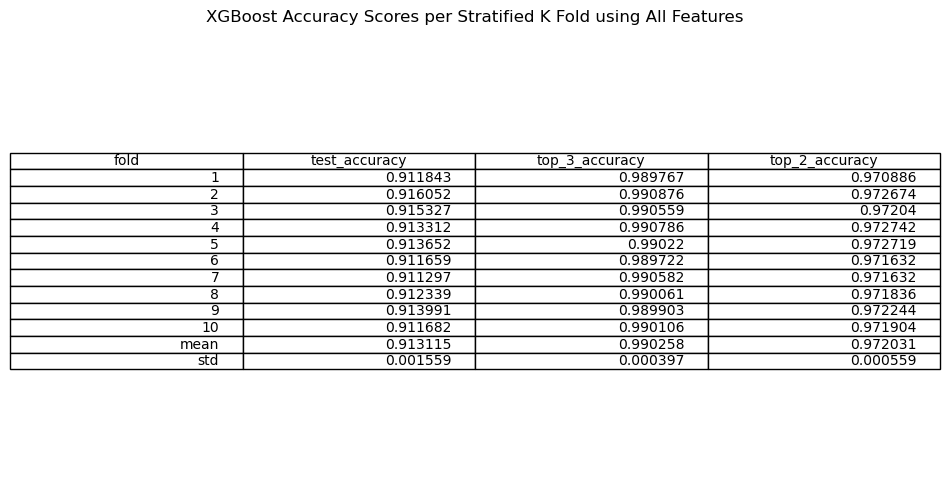

In [11]:
FEATURE_GROUP = "cascade_1"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)

lda = LinearDiscriminantAnalysis()
lda_scaled_longformer_urls = lda.fit_transform(scaled_longformer_urls, df['label'])
lda_scaled_distilbert_urls = lda.fit_transform(scaled_distilbert_urls, df['label'])
lda_scaled_longformer_urls_df = pd.DataFrame(lda_scaled_longformer_urls, columns=[f'longformer_embedding_{i}' for i in range(len(lda_scaled_longformer_urls[-1]))])
lda_scaled_distilbert_urls_df = pd.DataFrame(lda_scaled_distilbert_urls, columns=[f'distilbert_embedding_{i}' for i in range(len(lda_scaled_distilbert_urls[-1]))])
df = pd.concat([df, lda_scaled_longformer_urls_df, lda_scaled_distilbert_urls_df], axis=1)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)
df['label'], _ = column_adjustor(df['label'])
df['label'] = df['label'].astype(int)
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label']
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

np.set_printoptions(precision=2)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold + 1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout
plt.title("XGBoost Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [12]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
distilbert_embedding_0    25.468567%               
distilbert_embedding_1    7.836546%                
tld_transfer_price        4.902933%                
ratio_digits_hostname     4.243525%                
ratio_digits_url          3.474963%                
sitemap_count             3.410824%                
url_length                2.875555%                
tld_renew_price           2.870510%                
distilbert_embedding_2    2.830849%                
number_subdomains         2.614250%                
domain_length             2.439205%                
tld                       2.387700%                
unique_url_nums           2.335088%                
num_hyphens               2.258624%                
hostname_length           2.142552%                
robots_txt_len            1.813830%                
num_semicolons            1.564710%                
tld_register_price        1.542433%                
longformer_e

# Cascade 2

1
2
3
4
5
6
7
8
9
10


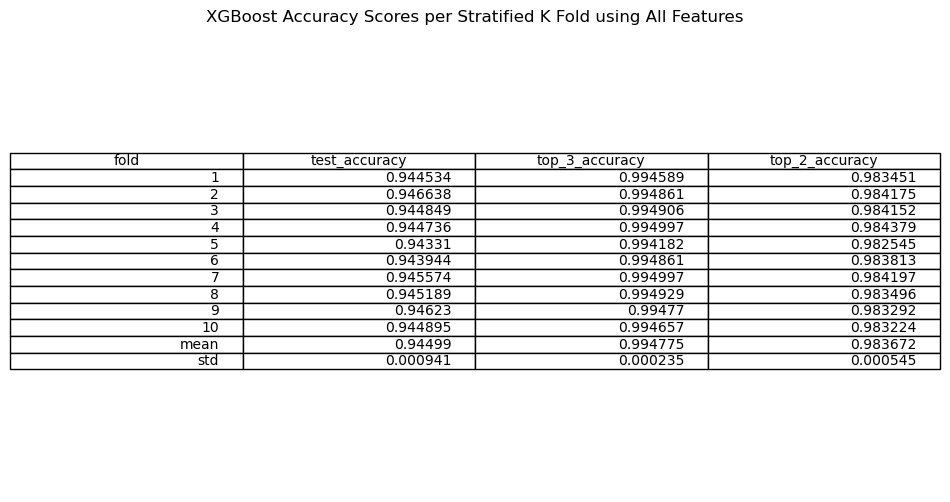

In [13]:
FEATURE_GROUP = "cascade_2"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)

lda = LinearDiscriminantAnalysis()
lda_scaled_longformer_urls = lda.fit_transform(scaled_longformer_urls, df['label'])
lda_scaled_distilbert_urls = lda.fit_transform(scaled_distilbert_urls, df['label'])
lda_scaled_longformer_urls_df = pd.DataFrame(lda_scaled_longformer_urls, columns=[f'longformer_embedding_{i}' for i in range(len(lda_scaled_longformer_urls[-1]))])
lda_scaled_distilbert_urls_df = pd.DataFrame(lda_scaled_distilbert_urls, columns=[f'distilbert_embedding_{i}' for i in range(len(lda_scaled_distilbert_urls[-1]))])
df = pd.concat([df, lda_scaled_longformer_urls_df, lda_scaled_distilbert_urls_df], axis=1)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)
df['label'], _ = column_adjustor(df['label'])
df['label'] = df['label'].astype(int)
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label']
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

np.set_printoptions(precision=2)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold + 1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout
plt.title("XGBoost Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [14]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
distilbert_embedding_0    21.550724%               
distilbert_embedding_1    6.375312%                
sitemap_count             3.367639%                
tld_transfer_price        3.000583%                
ratio_digits_hostname     2.977714%                
ratio_digits_url          2.965498%                
css_len                   2.618747%                
ratio_digits_domain       2.404917%                
external_css_len          2.352173%                
unique_url_nums           2.293446%                
url_length                2.256678%                
external_js_length        2.166082%                
distilbert_embedding_2    2.018402%                
external_js_function_count 1.890451%                
img_srcs_count            1.773769%                
tld                       1.663024%                
number_subdomains         1.551190%                
domain_length             1.534514%                
hostname_le

# Cascade 3

1
2
3
4
5
6
7
8
9
10


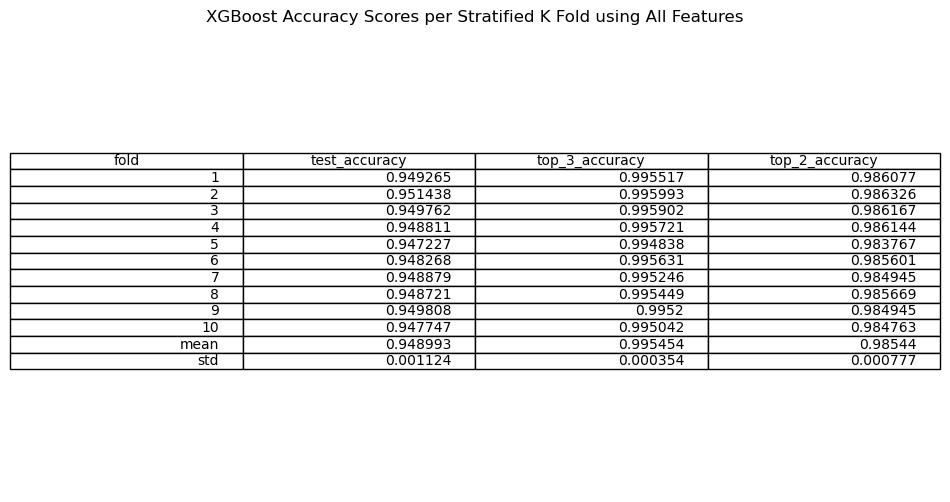

In [9]:
FEATURE_GROUP = "cascade_3"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)

lda = LinearDiscriminantAnalysis()
lda_scaled_longformer_urls = lda.fit_transform(scaled_longformer_urls, df['label'])
lda_scaled_distilbert_urls = lda.fit_transform(scaled_distilbert_urls, df['label'])
lda_scaled_longformer_urls_df = pd.DataFrame(lda_scaled_longformer_urls, columns=[f'longformer_embedding_{i}' for i in range(len(lda_scaled_longformer_urls[-1]))])
lda_scaled_distilbert_urls_df = pd.DataFrame(lda_scaled_distilbert_urls, columns=[f'distilbert_embedding_{i}' for i in range(len(lda_scaled_distilbert_urls[-1]))])
df = pd.concat([df, lda_scaled_longformer_urls_df, lda_scaled_distilbert_urls_df], axis=1)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)
df['label'], _ = column_adjustor(df['label'])
df['label'] = df['label'].astype(int)
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label']
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

np.set_printoptions(precision=2)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold + 1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout
plt.title("XGBoost Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [10]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
distilbert_embedding_0    21.125367%               
distilbert_embedding_1    5.818226%                
unique_hostnames_count    3.449318%                
sitemap_count             2.873200%                
tld_transfer_price        2.653635%                
ratio_digits_url          2.468442%                
css_len                   2.413534%                
passive_dns_len           2.287295%                
url_length                2.125661%                
external_js_length        2.065760%                
ratio_digits_hostname     2.036504%                
external_css_len          1.978107%                
ratio_digits_domain       1.753841%                
distilbert_embedding_2    1.734686%                
external_js_function_count 1.696569%                
unique_url_nums           1.633669%                
tld                       1.609379%                
img_srcs_count            1.511405%                
false_posit

## All Features

1
2
3
4
5
6
7
8
9
10


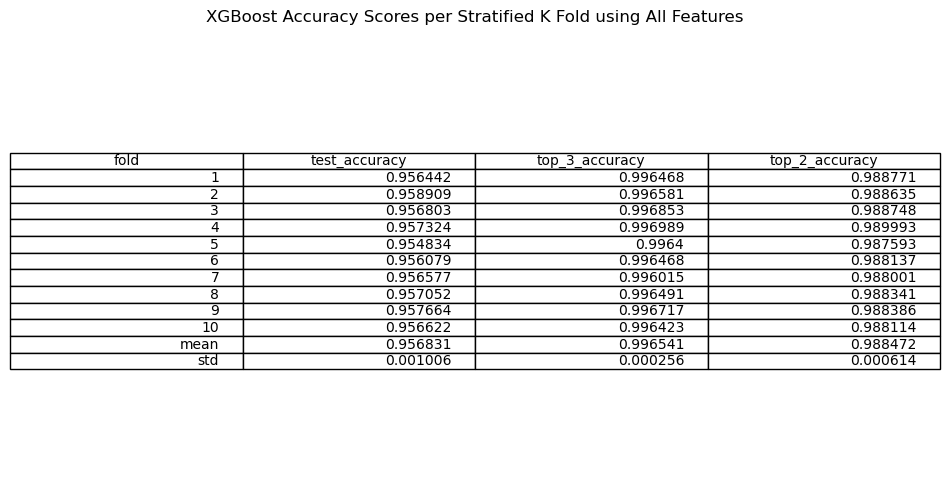

In [11]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)

lda = LinearDiscriminantAnalysis()
lda_scaled_longformer_urls = lda.fit_transform(scaled_longformer_urls, df['label'])
lda_scaled_distilbert_urls = lda.fit_transform(scaled_distilbert_urls, df['label'])
lda_scaled_longformer_urls_df = pd.DataFrame(lda_scaled_longformer_urls, columns=[f'longformer_embedding_{i}' for i in range(len(lda_scaled_longformer_urls[-1]))])
lda_scaled_distilbert_urls_df = pd.DataFrame(lda_scaled_distilbert_urls, columns=[f'distilbert_embedding_{i}' for i in range(len(lda_scaled_distilbert_urls[-1]))])
df = pd.concat([df, lda_scaled_longformer_urls_df, lda_scaled_distilbert_urls_df], axis=1)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)
df['label'], _ = column_adjustor(df['label'])
df['label'] = df['label'].astype(int)
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])
df = df.drop(columns=['ip_address'])
for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label']
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

np.set_printoptions(precision=2)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold + 1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout
plt.title("XGBoost Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [12]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
distilbert_embedding_0    21.015096%               
distilbert_embedding_1    5.830526%                
registrar                 3.265770%                
unique_hostnames_count    2.985094%                
sitemap_count             2.983559%                
css_len                   2.780249%                
passive_dns_len           2.380914%                
ratio_digits_url          2.081535%                
external_css_len          2.065960%                
external_js_length        2.029913%                
tld_transfer_price        1.966848%                
ratio_digits_hostname     1.965795%                
unique_url_nums           1.878610%                
ratio_digits_domain       1.868025%                
distilbert_embedding_2    1.804727%                
num_hyphens               1.666841%                
img_srcs_count            1.457350%                
tld_renew_price           1.431170%                
false_positi